In [9]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from copy import deepcopy
import math

import optuna


import datetime
from functools import reduce

from itertools import product
from tqdm import tqdm

from pykalman import KalmanFilter, UnscentedKalmanFilter

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

import xgboost as xgb
import joblib

# from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# import tensorflow as tf
# from sklearn.model_selection import KFold

# from keras.losses import KLDivergence

# from keras import backend as K

# from keras.optimizers import SGD
# from keras.models import *
# from keras.layers import *
# from scikeras.wrappers import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from tensorflow.keras.constraints import MaxNorm
# from tensorflow.keras.callbacks import *

from joblib import Parallel, delayed

class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_col):
        """Encode the data based on object column provided
        """
        self.object_col = object_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dummy_df = pd.get_dummies(X[self.object_col], drop_first=True)
        X = X.drop(X[self.object_col], axis=1)
        X = pd.concat([dummy_df, X], axis=1)
        return X
    
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_cols):
        """Encode the data based on object columns provided using label encoding
        """
        self.object_cols = object_cols
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.object_cols:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders[col] = encoder
        return self

    def transform(self, X, y=None):
        for col, encoder in self.encoders.items():
            X[col] = encoder.transform(X[col])
        return X
    
class CustomNumericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, object_col):
        """Encode the data based on object column provided
        """
        self.object_col = object_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sc = StandardScaler()
        X[self.object_col] = sc.fit_transform(X[self.object_col])
        return X
    
class CustomTimeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, time_col):
        self.object_col = time_col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.object_col == 'Horaire théorique':
            X['sin_time'] = np.sin(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
            X['cos_time'] = np.cos(2 * np.pi * pd.to_timedelta(X[self.object_col].astype(str)).dt.total_seconds()/86400)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'Semaine':
            X['semaine_sin_time'] = np.sin(2 * np.pi * X[self.object_col]/52)
            X['semaine_cos_time'] = np.cos(2 * np.pi * X[self.object_col]/52)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'month':
            X['month_sin_time'] = np.sin(2 * np.pi * X[self.object_col]/12)
            X['month_cos_time'] = np.cos(2 * np.pi * X[self.object_col]/12)
            X = X.drop(self.object_col, axis=1)
        if self.object_col == 'Local Date':
            X = X.drop(self.object_col, axis=1)
        return X
    
    
class CustomTargetRepartitionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.object_col = target_col
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        y[self.object_col] = y[self.object_col].astype(int)
        y['tot_sum'] = y.loc[:, self.object_col].sum(axis=1)
        for c in self.object_col:
            y[c] /= y['tot_sum']
        
        y.drop('tot_sum', axis=1,inplace=True)
        return y

def print_num_vol(df, col_libel, terminaux):
    x = df.loc[(df['A/D'] == 'D') & (df[col_libel].isin(terminaux))]
    s = ""
    for n in pd.unique(x['Num Vol']):
        s += n + ";"

    # to copy/paste for SAPBO request
    print("Vols:")
    print(s)
    print("Nombre de vol sur la période:", len(pd.unique(x['Num Vol'])))
    print()

    txt_file = open('liste_num_vol.txt', 'w')
    txt_file.write(s[:-1])
    txt_file.close()


def UKS(y, smoothing_factor=50):
    ukf = UnscentedKalmanFilter(observation_covariance=smoothing_factor)
    (filtered_state_means, _) = ukf.filter(y)
    return filtered_state_means



def STR_TO_DT(df, col_horaire):
    df_temp = df
    l_dt = []
    for t in range(df.shape[0]):
        TSTR =  str(df[col_horaire][t])
        if len(TSTR)<10:
            l = [int(i) for i in TSTR.split(':')]
            l_dt.append(datetime.time(hour=l[0], minute=l[1], second=0))
        else:
            TSTR = TSTR[10:]
            l = [int(i) for i in TSTR.split(':')]
            l_dt.append(datetime.time(hour=l[0], minute=l[1], second=0))
    
    df[col_horaire] = l_dt
    return df_temp


def cat_num_col(df):
        
    numerical_col = ['Local Date', 'Horaire théorique', 'Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']
    categorical_col_bool = ~df.columns.isin(numerical_col)
    categorical_col = []

    for c, i in zip(df.columns, range(len(df.columns))):
        if categorical_col_bool[i] == True:
            categorical_col.append(c)
    categorical_col

    df[categorical_col] = df[categorical_col].astype(str)

    return df


def get_x_previ_df(path, sheet_name, col_horaire):
    df = pd.read_excel(path, sheet_name)
    df.drop(['Unnamed: 0', 'Affectation', 'Etat du vol'], axis=1, inplace=True)
    df['Porteur'].fillna('MP', inplace=True)
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_Inter","Terminal 1")
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_5","Terminal 1_5")
    df['Libellé terminal'] = df['Libellé terminal'].str.replace("T1_6","Terminal 1_6")
    df['Cie Ope'].dropna(inplace=True)
    df['Num Vol'].dropna(inplace=True)

    numerical_col = ['Local Date', 'Horaire théorique', 'Pax LOC TOT', 'Pax CNT TOT', 'PAX TOT']
    categorical_col = ~df.columns.isin(numerical_col)

    l_date = pd.to_datetime(df['Local Date'].unique().tolist()).date
    l_date = sorted(l_date)

    df_pgrm = STR_TO_DT(df, col_horaire)
    return df_pgrm, l_date

def get_x_rea_df(path_file):
    x_rea_df = pd.read_csv(path_file, sep=',')
    x_rea_df.rename(columns=
                    {"Année":"Year", 
                    "Mois":"month",
                    "Plage Hub":"Plage",
                    "Type porteur":"Porteur",
                    "Code aéroport IATA":"Prov Dest",
                    "Code IATA compagnie":'Cie Ope',
                    "Type de mouvement":"A/D",
                    "Terminal":"Libellé terminal",
                    "Nombre de passagers réalisés":"PAX TOT",
                    "Jour":"Local Date",
                    "Numéro de vol":"Num Vol",
                    "Type de contact":"Contact/Large",
                    "Heure théorique":'Horaire théorique'},
                    inplace=True)

    x_rea_df['Local Date'] = pd.to_datetime(x_rea_df['Local Date'], format="%d/%m/%Y")
    x_rea_df['Local Date'] = x_rea_df['Local Date'].apply(lambda x: x.strftime("%d/%m/%Y"))

    x_rea_df['Horaire théorique'] = pd.to_datetime(x_rea_df['Horaire théorique'], format="%H:%M", errors='coerce').dt.time
    x_rea_df[['Pax LOC TOT', 'Pax CNT TOT']] = 0

    x_rea_df['A/D'] = x_rea_df['A/D'].str.replace("Départ","D")
    x_rea_df['A/D'] = x_rea_df['A/D'].str.replace("Arrivée","A")

    # x_rea_df['Contact/large'] = x_rea_df['Contact/Large'].str.replace("au contact","Contact")
    # x_rea_df['Contact/large'] = x_rea_df['Contact/Large'].str.replace("au large","Large")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle L","T2E-L")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle K","T2E-K")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle L","T2E-L")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle M","T2E-M")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("D","T2D")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("B","T2B")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("A","T2A")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("salle M","T2E-M")

    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("Jonction","Terminal 1")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("sat5","Terminal 1_5")
    x_rea_df['Salle corrigée'] = x_rea_df['Salle corrigée'].str.replace("sat6","Terminal 1_6")

    ind = x_rea_df['Salle corrigée'].loc[x_rea_df['Salle corrigée'].isin(['Terminal 1', 'Terminal 1_5', 'Terminal 1_6'])].index
    x_rea_df['Libellé terminal'].iloc[ind] = x_rea_df['Salle corrigée'].iloc[ind]

    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Lundi","Monday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Mardi","Thuesday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Mercredi","Wednesday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Jeudi","Thursday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Vendredi","Friday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Samedi","Saturday")
    x_rea_df['Jour de la semaine'] = x_rea_df['Jour de la semaine'].str.replace("Dimanche","Sunday")


    x_rea_df['Porteur'] = x_rea_df['Porteur'].str.replace('Gros porteur', "GP")
    x_rea_df['Porteur'] = x_rea_df['Porteur'].str.replace('Moyen porteur', "MP")
    
    try:
        x_rea_df.drop(['Compagnie' ,'Contact/Large', 'Immatriculation'], axis=1, inplace=True)
    except ValueError:
        pass

    x_rea_df = x_rea_df.dropna().reset_index(drop=True)
    x_rea_df = cat_num_col(x_rea_df)

    # ajout des vacances / jours fériés / ponts / grèves
    calendrier_gouv = pd.read_csv(r"calendar_complete_from_data_gouv.csv", sep=',')
    calendrier_gouv['date'] = pd.to_datetime(calendrier_gouv['date'], format="%Y-%m-%d")
    calendrier_gouv['date'] = calendrier_gouv['date'].apply(lambda x: x.strftime("%d/%m/%Y"))
    print("date exemple rea :", x_rea_df['Local Date'].iloc[0])
    print("date exemple calendrier :", calendrier_gouv['date'].iloc[0])


    calendrier_gouv.fillna('non_ferie', inplace=True)
    x_rea_df = pd.merge(x_rea_df, calendrier_gouv, left_on='Local Date', right_on='date', how='left')
    x_rea_df.drop(columns=['date'], axis=1, inplace=True)
    return x_rea_df

def kalman_smoothing(y):
    kf = KalmanFilter(transition_matrices=[1],
                    observation_matrices=[1],
                    initial_state_mean=0,
                    initial_state_covariance=1,
                    observation_covariance=1,
                    transition_covariance=1)
    
    kf.em(y)
    smoothed_state_means, _ = kf.smooth(y)
    return smoothed_state_means.flatten()

def compute_ma(df, vol, col, window):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > window:
        x = x.rolling(window).mean().bfill()
    elif x.shape[0] > 1:
        x = x.rolling(x.shape[0]-1).mean().bfill()
    return x

def compute_ewm(df, vol, col, window):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > 1:
        x = x.ewm(span=window).mean().bfill()
    return x

def compute_ewm_std(df, vol, col, window):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > 1:
        x = x.ewm(span=window).std().bfill()
    return x

def compute_kalman(df, vol, col):
    x = df.loc[df['Num Vol'] == vol][col]
    if x.shape[0] > 1:
        x = kalman_smoothing(x)
    return x

In [10]:
path_file = r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\pgrm\x_rea_pgrm.csv'
x_rea_df = get_x_rea_df(path_file)

liste_greve = ['27/03/2023', '01/05/2023', '02/10/2023']
ind_greve = x_rea_df.loc[x_rea_df['Local Date'].isin(liste_greve)].index

x_rea_df.drop(ind_greve, axis=0, inplace=True)
x_rea_df.reset_index(drop=True, inplace=True)

path_y = r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml'
sheet_name_y = r"\rea\y_rea_repartition.csv"

f = lambda s: datetime.datetime.strptime(s,'%d/%m/%Y')
y_rea_repartition = pd.read_csv(path_y + sheet_name_y, sep=',',date_parser=f).fillna(0)
y_rea_repartition.columns = ['Jour', 'Numéro de vol', 'ABCDT1', 
                                'EK', 'EL', 'EM', 'N/A', 'F', 'G']
y_rea_repartition.drop(['N/A'], axis=1, inplace=True)

data_rea_repartition = pd.merge(x_rea_df, y_rea_repartition, left_on=['Local Date', 'Num Vol'], right_on=['Jour', 'Numéro de vol'], how='right')
data_rea_repartition.drop(['Jour', 'Numéro de vol'], axis=1, inplace=True)
data_rea_repartition.dropna(inplace=True)
data_rea_repartition = data_rea_repartition.loc[data_rea_repartition['A/D'] == 'A']


target_col_repartition = ['ABCDT1', 'EK', 'EL', 'EM', 'F', 'G']

col_test_pred = ['A/D', 'Cie Ope', 'Num Vol', 'Prov Dest', 'Libellé terminal', 'Jour de la semaine', 'Horaire théorique', 
                    'Semaine', 'month', 'Local Date', 'Faisceau géographique', 'Porteur',
                    'Zone A', 'Zone B', 'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
                    'is_ferie', 'nom_jour_ferie'] + target_col_repartition

label_col = ['A/D', 'Cie Ope', 'Num Vol', 'Prov Dest', 'Libellé terminal', 'Jour de la semaine', 'Horaire théorique', 
                    'Semaine', 'month', 'Faisceau géographique', 'Porteur',
                    'Zone A', 'Zone B', 'Zone C', 'Zone A vacance', 'Zone B vacance', 'Zone C vacance', 
                    'is_ferie', 'nom_jour_ferie'] 

################### REGROUPER LES DONNEES TEMPORALLEMENT ####################
col_unique_date = ['Local Date', 'month', 'Jour de la semaine', 'Plage']
data_rea_repartition_grouped = data_rea_repartition.groupby(by=col_unique_date)[target_col_repartition].mean().reset_index()
data_rea_repartition = data_rea_repartition.merge(data_rea_repartition_grouped, on=col_unique_date, how='left', suffixes=('', '_grouped'))

data_rea_repartition[target_col_repartition] = data_rea_repartition[[f"{t}_grouped" for t in target_col_repartition]]
data_rea_repartition.drop(columns=[f"{t}_grouped" for t in target_col_repartition], axis=1, inplace=True)


# ################### REGROUPER LES DONNEES SPATIALEMENT ####################
# col_unique_id_group = ['Local Date', 'Cie Ope', 'Prov Dest', 'Plage']
# data_rea_repartition_grouped = data_rea_repartition.groupby(by=col_unique_id_group)[target_col_repartition].mean().reset_index()
# data_rea_repartition = data_rea_repartition.merge(data_rea_repartition_grouped, on=col_unique_id_group, how='left', suffixes=('', '_grouped'))

# data_rea_repartition[target_col_repartition] = data_rea_repartition[[f"{t}_grouped" for t in target_col_repartition]]
# data_rea_repartition.drop(columns=[f"{t}_grouped" for t in target_col_repartition], axis=1, inplace=True)


data_col_pred = deepcopy(data_rea_repartition[col_test_pred])

data_col_pred['Local Date'].dropna(inplace=True)
data_col_pred['Year'] = pd.to_datetime(data_col_pred['Local Date'], format="%d/%m/%Y").dt.year

# data_col_pred['Taux Correspondance'] = data_col_pred[target_col_repartition].sum(axis=1) / data_col_pred['PAX TOT']
# data_col_pred.drop(columns=['PAX TOT'], axis=1, inplace=True)

data_train = deepcopy(data_col_pred) # on copie car on inversera les classes pour l'affichage des résultats
data_train = data_train.loc[data_train['Year'] < 2023]
data_test = deepcopy(data_col_pred) # on copie car on inversera les classes pour l'affichage des résultats (== désencodage)
data_test = data_test.loc[data_test['Year'] >= 2023]

data_train.drop(['Year'], axis=1, inplace=True)
data_test.drop(['Year'], axis=1, inplace=True)
data_col_pred.drop(['Year'], axis=1, inplace=True)

C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_rea_df['Libellé terminal'].iloc[ind] = x_rea_df['Salle corrigée'].iloc[ind]


date exemple rea : 03/01/2022
date exemple calendrier : 01/09/2017


In [11]:
def prepare_ML_xgb(df, label_col, target_col_repartition, isRepartition=True):
    data = deepcopy(df)
    preprocessing_pipe_taux_presentation = Pipeline(
        steps=[
            ('label_encoder', CustomLabelEncoder(label_col)),
            ('time_encoder_horaire', CustomTimeEncoder('Horaire théorique')),
            ('time_encoder_semaine', CustomTimeEncoder('Semaine')),
            ('time_encoder_month', CustomTimeEncoder('month')),
            # ('date_droping', CustomTimeEncoder('Local Date')),
            # ('standard_scaling', CustomNumericalEncoder(scalable_numerical_col))
        ]
    )

    del data['Local Date']


    data.reset_index(drop=True, inplace=True)
    # data_col_pred.loc[:, target_col] = data_col_pred[target_col].apply(lambda x: ast.literal_eval(x))

    data_x, data_y = data.drop(columns=target_col_repartition, axis=1), data[target_col_repartition]


    data_x = preprocessing_pipe_taux_presentation.fit_transform(data_x)

    if isRepartition:
        data_y = pd.DataFrame(CustomTargetRepartitionEncoder(target_col_repartition).fit_transform(data_y), index=data_x.index)
        data_y.drop(index=data_x.loc[data_x.isna().any(axis=1)].index, inplace=True)
        data_x.drop(index=data_x.loc[data_x.isna().any(axis=1)].index, inplace=True)
    


    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42, shuffle=False)

    ind_train = y_train.loc[y_train.isna().any(axis=1)].index
    X_train.drop(index=ind_train, inplace=True)
    y_train.drop(index=ind_train, inplace=True)

    ind_test = y_test.loc[y_test.isna().any(axis=1)].index
    X_test.drop(index=ind_test, inplace=True)
    y_test.drop(index=ind_test, inplace=True)

    # X_train_light = X_train.iloc[:int(0.1*len(X_train)), :]
    # y_train_light = y_train.iloc[:int(0.1*len(y_train)), :]
    # X_test_light = X_test.iloc[:int(0.1*len(X_test)), :]
    # y_test_light = y_test.iloc[:int(0.1*len(y_test)), :]

    # print(f"X_train_light shape: {X_train_light.shape}")
    # print(f"X_test_light shape: {X_test_light.shape}")
    # print(f"y_train_light shape: {y_train_light.shape}")
    # print(f"y_test_light shape: {y_test_light.shape}")

    return X_train, X_test, y_train, y_test, preprocessing_pipe_taux_presentation


X_train, X_test, y_train, y_test, preprocessing_pipe_taux_presentation_test = prepare_ML_xgb(data_train, label_col, target_col_repartition)
X_full_train = pd.concat([X_train, X_test], axis=0)
y_full_train = pd.concat([y_train, y_test], axis=0)

print(f"X_full_train shape: {X_full_train.shape}")
print(f"y_full_train shape: {y_full_train.shape}")
print(f"X and Y NaN values : {X_full_train.isna().sum().sum(), y_full_train.isna().sum().sum()}\n")

X_train, X_test, y_train, y_test, preprocessing_pipe_taux_presentation_test = prepare_ML_xgb(data_test, label_col, target_col_repartition)
X_full_test = pd.concat([X_train, X_test], axis=0)
y_full_test = pd.concat([y_train, y_test], axis=0)

print(f"X_full_test shape: {X_full_test.shape}")
print(f"y_full_test shape: {y_full_test.shape}")
print(f"X and Y NaN values : {X_full_test.isna().sum().sum(), y_full_test.isna().sum().sum()}\n")


# X_train_cnt, X_test_cnt, y_train_cnt, y_test_cnt, preprocessing_pipe_taux_presentation_test = prepare_ML_xgb(data_train.loc[data_train['Taux Correspondance'] < 1].reset_index(drop=True), 
#                                                                                                             label_col, ['Taux Correspondance'], isRepartition=False)
# X_full_train_cnt = pd.concat([X_train_cnt, X_test_cnt], axis=0)
# y_full_train_cnt = pd.concat([y_train_cnt, y_test_cnt], axis=0)

# print(f"X_full_train_cnt shape: {X_full_train_cnt.shape}")
# print(f"y_full_train_cnt shape: {y_full_train_cnt.shape}")
# print(f"X and Y NaN values : {X_full_test.isna().sum().sum(), y_full_test.isna().sum().sum()}\n")


# X_train_cnt, X_test_cnt, y_train_cnt, y_test_cnt, preprocessing_pipe_taux_presentation_test = prepare_ML_xgb(data_test.loc[data_test['Taux Correspondance'] < 1].reset_index(drop=True), 
#                                                                                                              label_col, ['Taux Correspondance'], isRepartition=False)
# X_full_test_cnt = pd.concat([X_train_cnt, X_test_cnt], axis=0)
# y_full_test_cnt = pd.concat([y_train_cnt, y_test_cnt], axis=0)

# print(f"X_full_test_cnt shape: {X_full_test_cnt.shape}")
# print(f"y_full_test_cnt shape: {y_full_test_cnt.shape}")
# print(f"X and Y NaN values : {X_full_test.isna().sum().sum(), y_full_test.isna().sum().sum()}\n")


C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[self.object_col] = y[self.object_col].astype(int)
C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['tot_sum'] = y.loc[:, self.object_col].sum(axis=1)
C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

X_full_train shape: (108157, 22)
y_full_train shape: (108157, 6)
X and Y NaN values : (0, 0)

X_full_test shape: (108903, 22)
y_full_test shape: (108903, 6)
X and Y NaN values : (0, 0)



C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[self.object_col] = y[self.object_col].astype(int)
C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['tot_sum'] = y.loc[:, self.object_col].sum(axis=1)
C:\Users\nazzaren\AppData\Local\Temp\ipykernel_7228\154180094.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [5]:
class CustomXGBRegressor(xgb.XGBRegressor):
    def _objective_taux_rep(self, y_pred, y_true):
        mse = np.mean(np.square(y_pred - y_true))
        sum_pred = np.sum(np.abs(np.sum(y_pred, axis=1) - 1)) 
        total_loss = mse + 0.001 * sum_pred
        return total_loss

    # def _objective_taux_cnt(self, y_pred, y_true):
    #     mse = np.mean(np.square(y_pred - y_true))
    #     return mse
    
def objective(trial, X_train, y_train):
    # Define the hyperparameters to be optimized
    # n_estimators = trial.suggest_int('n_estimators', 700, 3000)
    # max_depth = trial.suggest_int('max_depth', 3, 30)
    # learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    # gamma = trial.suggest_float('gamma', 0.0, 1.0)
    # reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    # reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)
    # subsample = trial.suggest_float('subsample', 0.5, 1.0)
    # colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # n_estimators = trial.suggest_int('n_estimators', 1500, 3500)
    # max_depth = trial.suggest_int('max_depth', 3, 30)
    # learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
    # gamma = trial.suggest_float('gamma', 0.0, 1.0)
    # reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    # reg_lambda = trial.suggest_float('reg_lambda', 0.1, 1.0)
    # subsample = trial.suggest_float('subsample', 0.1, 1.0)
    # colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    

    # Create the custom XGBoost regressor and the MultiOutputRegressor
    # custom_xgb_reg = CustomXGBRegressor(
    #     n_estimators=n_estimators,
    #     max_depth=max_depth,
    #     learning_rate=learning_rate,
    #     gamma=gamma,
    #     reg_alpha=reg_alpha,
    #     reg_lambda=reg_lambda,
    #     subsample=subsample,
    #     colsample_bytree=colsample_bytree,
    #     random_state=42
    # )

    n_estimators = trial.suggest_int('n_estimators', 1500, 3500)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
    gamma = trial.suggest_float('gamma', 0.0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 1.0)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    max_delta_step = trial.suggest_int('max_delta_step', 0, 10)
    max_bin = trial.suggest_int('max_bin', 256, 1024)
    max_cat_to_onehot = trial.suggest_int('max_cat_to_onehot', 4, 32)
    nthread = trial.suggest_int('nthread', 1, 8)
   

    custom_xgb_reg = CustomXGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        max_delta_step=max_delta_step,
        max_bin=max_bin,
        max_cat_to_onehot=max_cat_to_onehot,
        nthread=nthread,
        random_state=42
    )


    model = MultiOutputRegressor(custom_xgb_reg, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    if y_train.shape[1] == 1:
        total_loss = custom_xgb_reg._objective_taux_cnt(y_pred, y_train)
    else:
        total_loss = custom_xgb_reg._objective_taux_rep(y_pred, y_train)
    return total_loss

In [ ]:
######### OPTIMISATION TAUX REPARTITION #########
study_rep = optuna.create_study(directions=['minimize'], study_name='Taux Répartition')
study_rep.optimize(lambda trial: objective(trial, X_full_train.to_numpy(), y_full_train.to_numpy()), n_trials=15)

In [ ]:
####### OPTIMISATION TAUX CORRESPONDANCE ########
# study_cnt = optuna.create_study(directions=['minimize'], study_name='Taux Correspondance')
# study_cnt.optimize(lambda trial: objective(trial, X_full_train_cnt.to_numpy(), y_full_train_cnt.to_numpy()), n_trials=100)

In [ ]:
custom_xgb_reg_rep = CustomXGBRegressor(**study_rep.best_trials[0].params)
xgb_rep = MultiOutputRegressor(custom_xgb_reg_rep, n_jobs=-1)
xgb_rep.fit(X_full_train, y_full_train)

In [ ]:
# custom_xgb_reg_cnt = CustomXGBRegressor(**study_cnt.best_trials[0].params)
# xgb_cnt = MultiOutputRegressor(custom_xgb_reg_cnt, n_jobs=-1)
# xgb_cnt.fit(X_full_train_cnt, y_full_train_cnt)

In [ ]:
custom_xgb_reg_rep = CustomXGBRegressor(**study_rep.best_trials[0].params)
xgb_rep = MultiOutputRegressor(custom_xgb_reg_rep, n_jobs=-1)

X = pd.concat([X_full_train, X_full_test], axis=0)
y = pd.concat([y_full_train, y_full_test], axis=0)
xgb_rep.fit(X, y)

In [ ]:
joblib.dump(xgb_rep, r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\repartition\courbe_rep_multiouput_xgb.json")

In [ ]:
# joblib.dump(xgb_cnt, r"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\repartition\courbe_cnt_multiouput_xgb.json")

In [12]:
xgb_rep = joblib.load(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\repartition\courbe_rep_multiouput_xgb.json')

In [7]:
# xgb_cnt = joblib.load(r'C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\repartition\courbe_cnt_multiouput_xgb.json')

In [13]:
def make_predictions(model, X_test, shape, is_corrected=True):
    col = list(range(0, shape, 1))
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=col, index=X_test.index)
    if is_corrected:
        return y_pred.apply(lambda x: x/sum(x), axis=1)
    else:
        return y_pred

def get_error(y_test, y_pred):
    error = (y_test.values - y_pred.values)
    error = pd.DataFrame(error, columns=y_test.columns, index=y_test.index)
    # error.fillna(0, inplace=True)
    return error

y_pred_not_corrected = make_predictions(xgb_rep, X_full_test, shape=y_full_test.shape[1], is_corrected=False)
y_pred = make_predictions(xgb_rep, X_full_test, shape=y_full_test.shape[1], is_corrected=True)


error = get_error(y_full_test, y_pred)

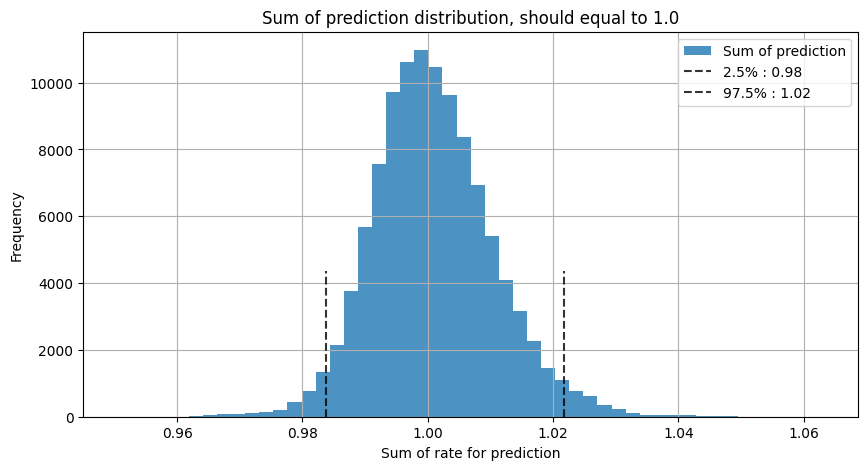

In [14]:
# BEFORE CORRECTION OF THE PREDICTION WITH THE SUM OF THE PREDICTION
y_pred_not_corrected.sum(axis=1).hist(bins=50, alpha=0.8, label='Sum of prediction', figsize=(10, 5))
plt.vlines(y_pred_not_corrected.sum(axis=1).quantile(0.025), 0, y_pred_not_corrected.shape[0]//25, color='black', label=f"2.5% : {y_pred_not_corrected.sum(axis=1).quantile(0.025).min():.2f}", linestyle='--', alpha=0.8)
plt.vlines(y_pred_not_corrected.sum(axis=1).quantile(0.975), 0, y_pred_not_corrected.shape[0]//25, color='black', label=f"97.5% : {y_pred_not_corrected.sum(axis=1).quantile(0.975).max():.2f}", linestyle='--', alpha=0.8)
plt.xlabel('Sum of rate for prediction')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sum of prediction distribution, should equal to 1.0')
plt.show()

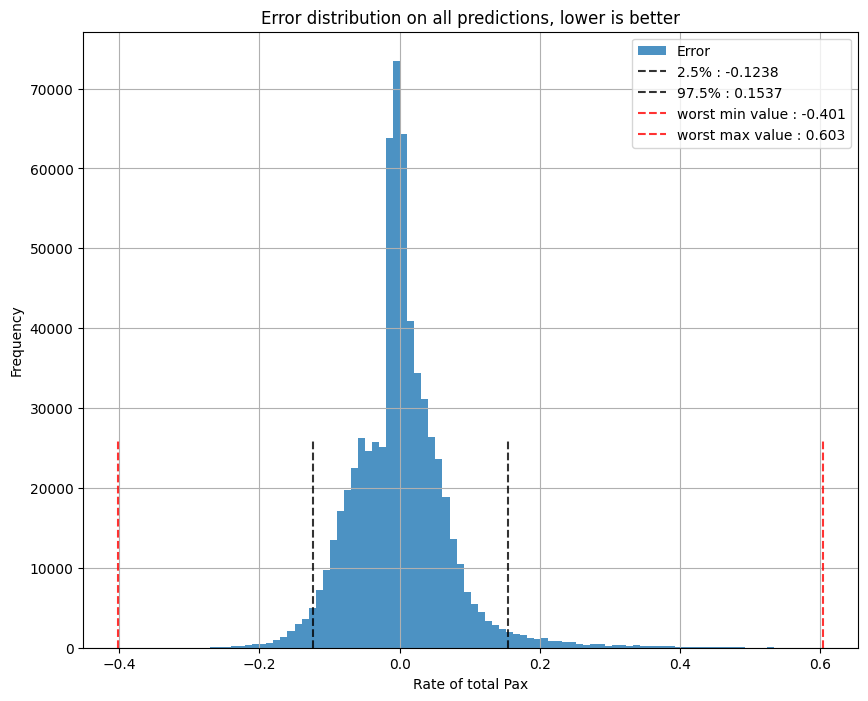

In [15]:
error.stack().reset_index(drop=True).hist(bins=100, alpha=0.8, label='Error', figsize=(10, 8))
plt.vlines(error.stack().reset_index(drop=True).quantile(0.025), 0, error.stack().reset_index(drop=True).shape[0]//25, color='black', label=f"2.5% : {error.stack().reset_index(drop=True).quantile(0.025).min():.4f}", linestyle='--', alpha=0.8)
plt.vlines(error.stack().reset_index(drop=True).quantile(0.975), 0, error.stack().reset_index(drop=True).shape[0]//25, color='black', label=f"97.5% : {error.stack().reset_index(drop=True).quantile(0.975).max():.4f}", linestyle='--', alpha=0.8)
plt.vlines(error.stack().reset_index(drop=True).min(), 0, error.stack().reset_index(drop=True).shape[0]//25, color='red', label=f"worst min value : {error.stack().reset_index(drop=True).min():.3f}", linestyle='--', alpha=0.8)
plt.vlines(error.stack().reset_index(drop=True).max(), 0, error.stack().reset_index(drop=True).shape[0]//25, color='red', label=f"worst max value : {error.stack().reset_index(drop=True).max():.3f}", linestyle='--', alpha=0.8)

plt.xlabel('Rate of total Pax')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error distribution on all predictions, lower is better')
plt.show()

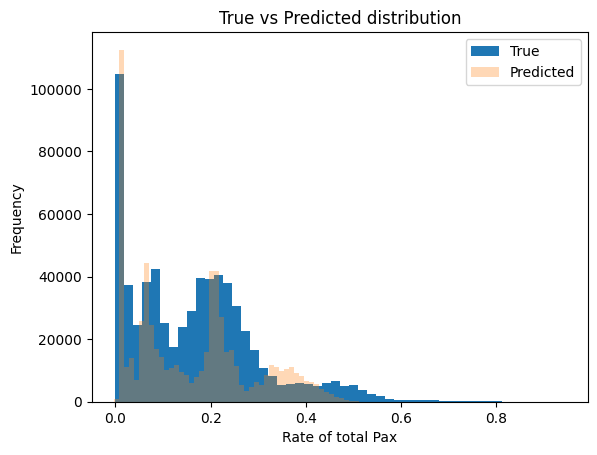

In [16]:
plt.hist(y_full_test.stack().reset_index(drop=True), bins=50, alpha=1, label='True')
plt.hist(y_pred.stack().reset_index(drop=True), bins=50, alpha=0.3, label='Predicted')
plt.xlabel('Rate of total Pax')
plt.ylabel('Frequency')
plt.legend()    
plt.title('True vs Predicted distribution')
plt.show()


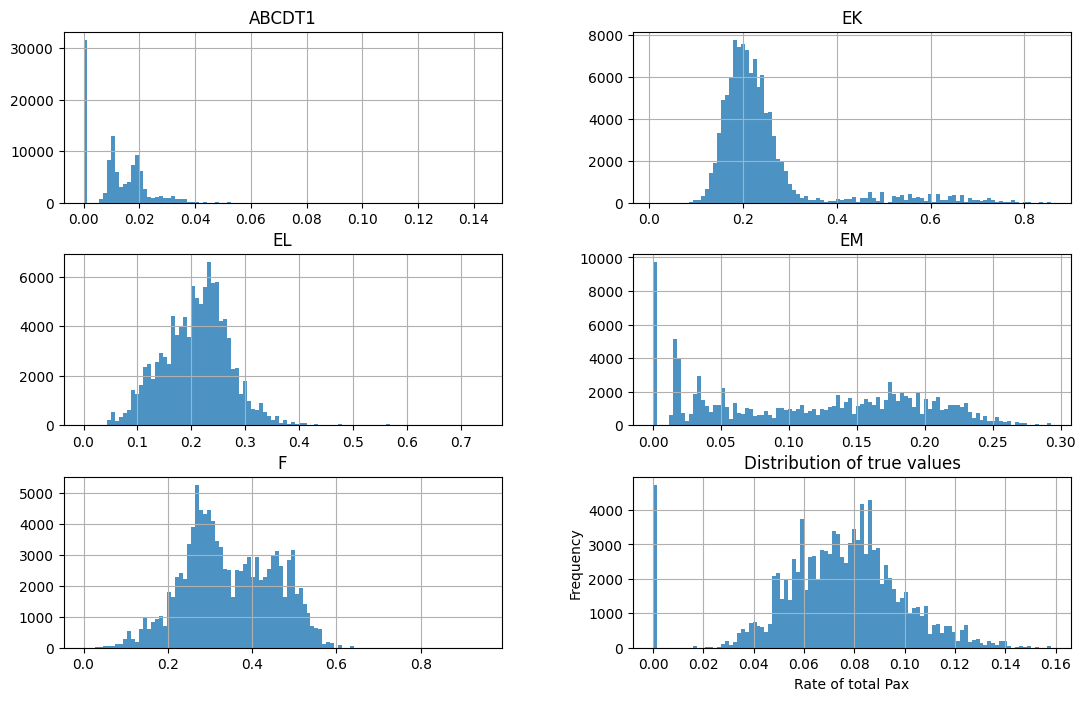

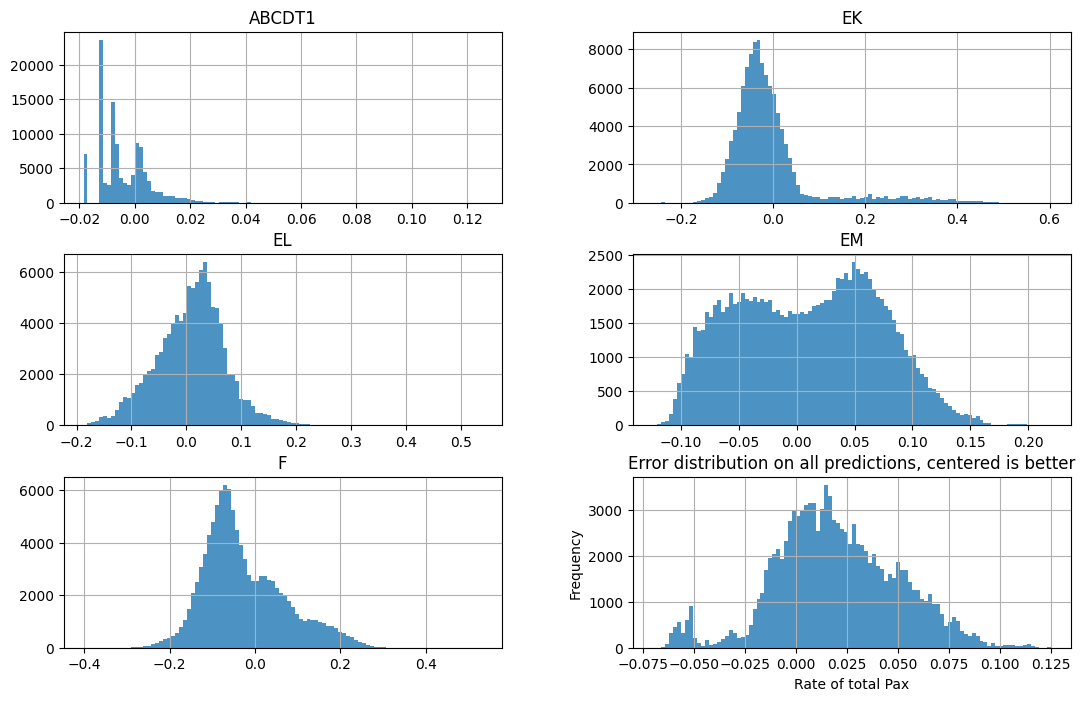

In [19]:
y_full_test.hist(bins=100, alpha=0.8, label='True', figsize=(13, 8))
plt.xlabel('Rate of total Pax')
plt.ylabel('Frequency')
plt.title('Distribution of true values')
plt.show()



error.hist(bins=100, alpha=0.8, figsize=(13, 8))
plt.xlabel('Rate of total Pax')
plt.ylabel('Frequency')
plt.title('Error distribution on all predictions, centered is better')
plt.show()

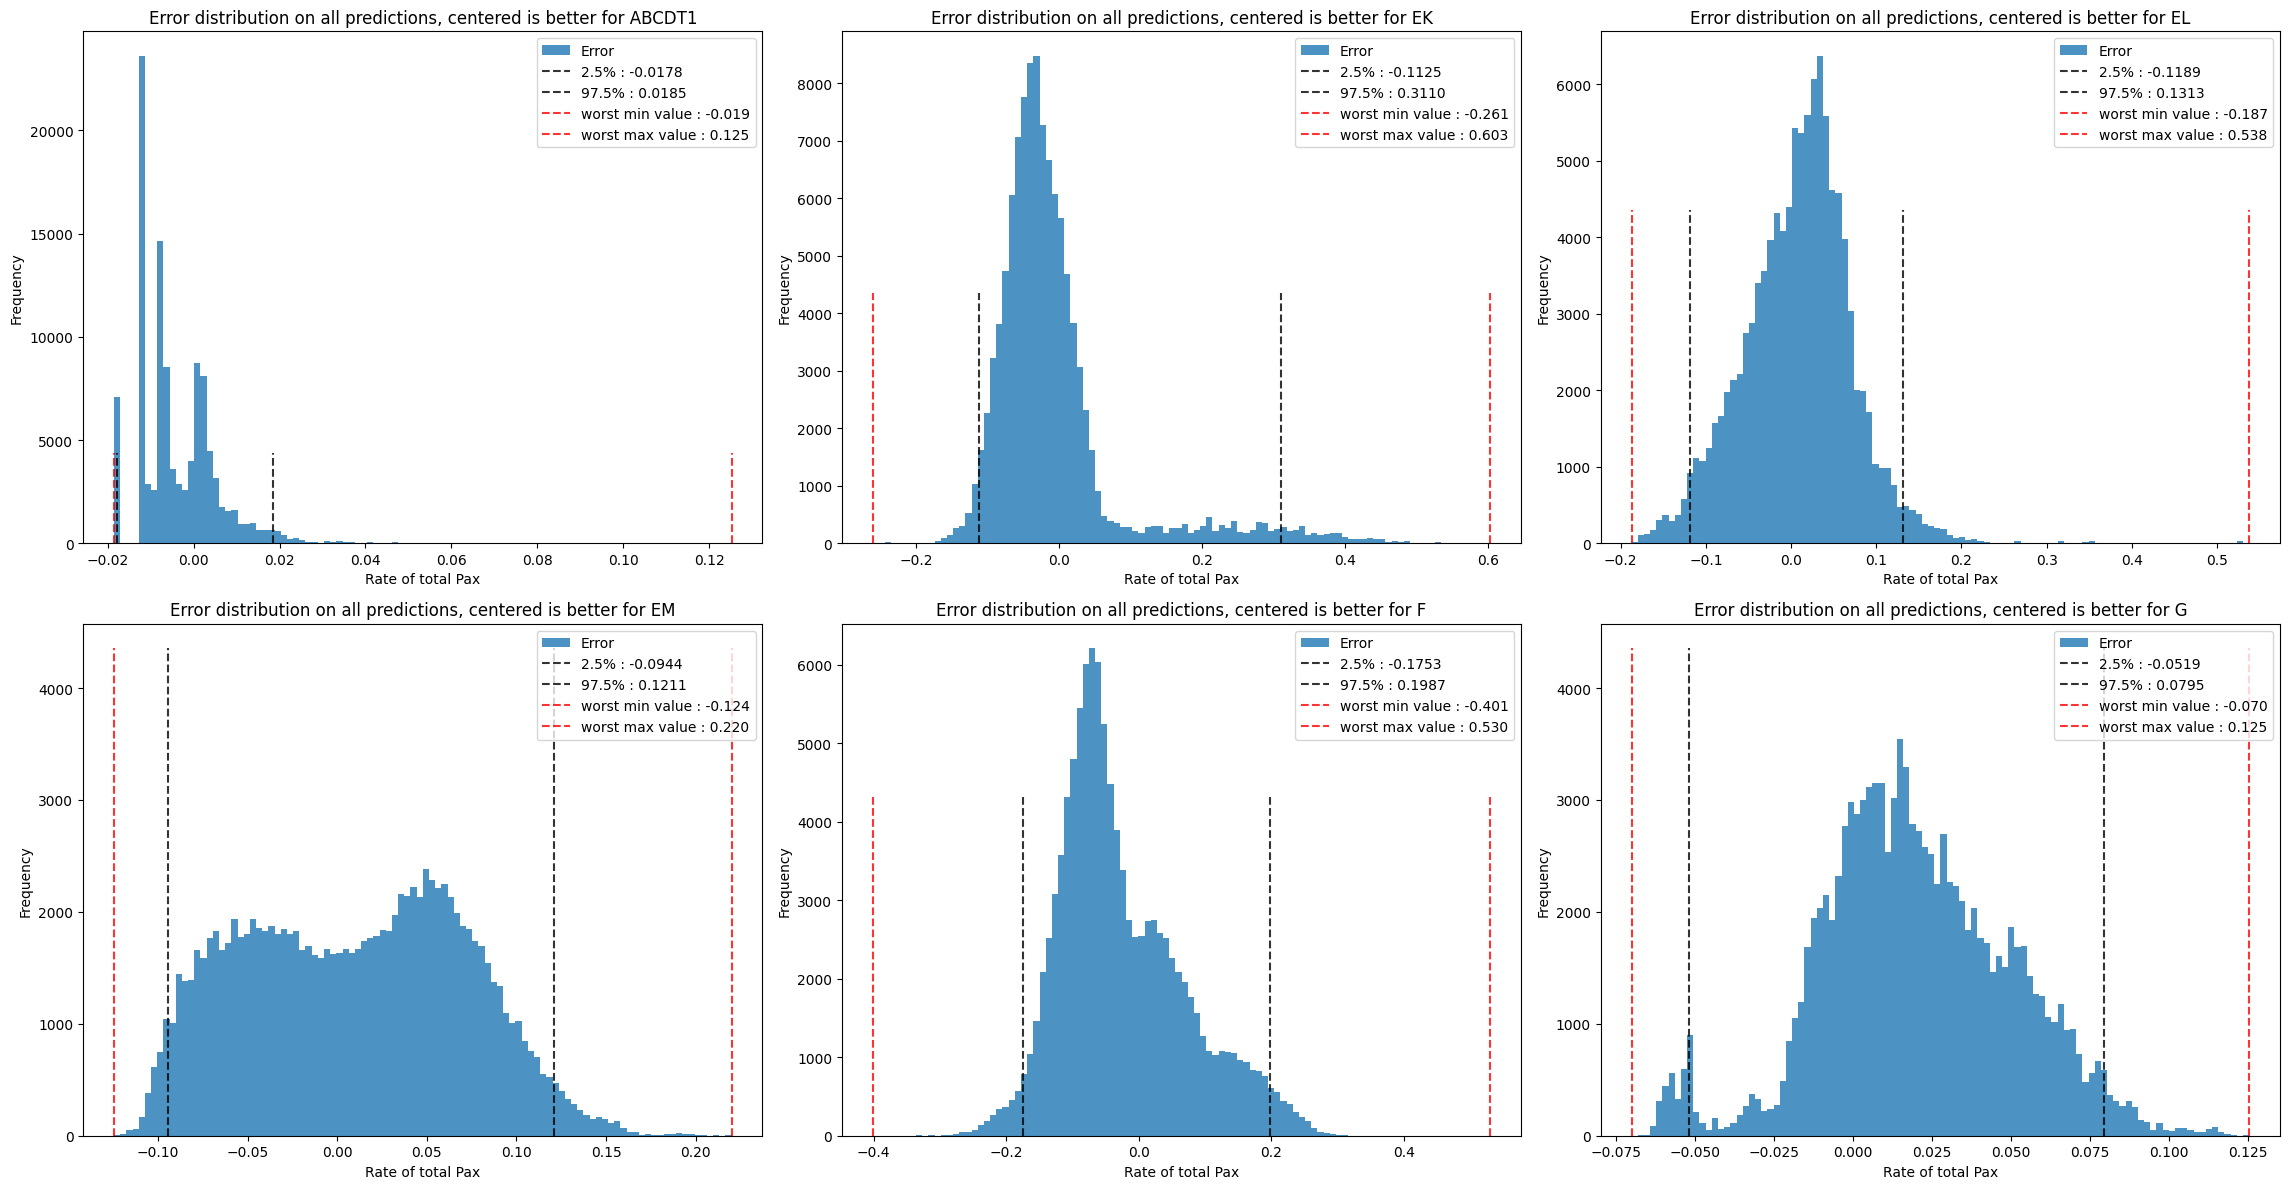

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(23, 12))
axs = axs.flatten()  # Flatten the axs array to iterate over it

metrics = []  # List to store metrics for each column

for i, c in enumerate(error.columns):
    e = error[c].dropna()
    axs[i].hist(e, bins=100, alpha=0.8, label='Error')
    axs[i].vlines(e.quantile(0.025), 0, e.shape[0]//25, color='black', label=f"2.5% : {e.quantile(0.025):.4f}", linestyle='--', alpha=0.8)
    axs[i].vlines(e.quantile(0.975), 0, e.shape[0]//25, color='black', label=f"97.5% : {e.quantile(0.975):.4f}", linestyle='--', alpha=0.8)
    axs[i].vlines(e.min(), 0, e.shape[0]//25, color='red', label=f"worst min value : {e.min():.3f}", linestyle='--', alpha=0.8)
    axs[i].vlines(e.max(), 0, e.shape[0]//25, color='red', label=f"worst max value : {e.max():.3f}", linestyle='--', alpha=0.8)

    axs[i].set_xlabel('Rate of total Pax')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].set_title(f'Error distribution on all predictions, centered is better for {c}')

    # Store metrics for the current column
    metrics.append({
        'column': c,
        'mean': e.mean(),
        'std': e.std(),
        'min': e.min(),
        'max': e.max(),
        'q2.5': e.quantile(0.025),
        'q97.5': e.quantile(0.975)
    })

plt.tight_layout()
plt.savefig(r"C:\Users\nazzaren\Pictures\repartition\hist_repartition_error.png")
plt.show()

# Save metrics to a CSV file
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(r"C:\Users\nazzaren\Pictures\repartition\error_metrics.csv", index=False, sep=';', decimal=',', float_format='%.3f', encoding='utf-8')

In [26]:
metrics_df

,column,mean,std,min,max,q2.5,q97.5
0,ABCDT1,-0.003890,0.009105,-0.018503,0.125197,-0.017780,0.018498
1,EK,-0.007926,0.094615,-0.261179,0.603474,-0.112458,0.310955
2,EL,0.008415,0.062677,-0.187243,0.537676,-0.118858,0.131310
3,EM,0.009333,0.061506,-0.124437,0.219993,-0.094395,0.121132
4,F,-0.025809,0.095963,-0.401206,0.530458,-0.175267,0.198673
5,G,0.019877,0.030367,-0.070186,0.125317,-0.051934,0.079528


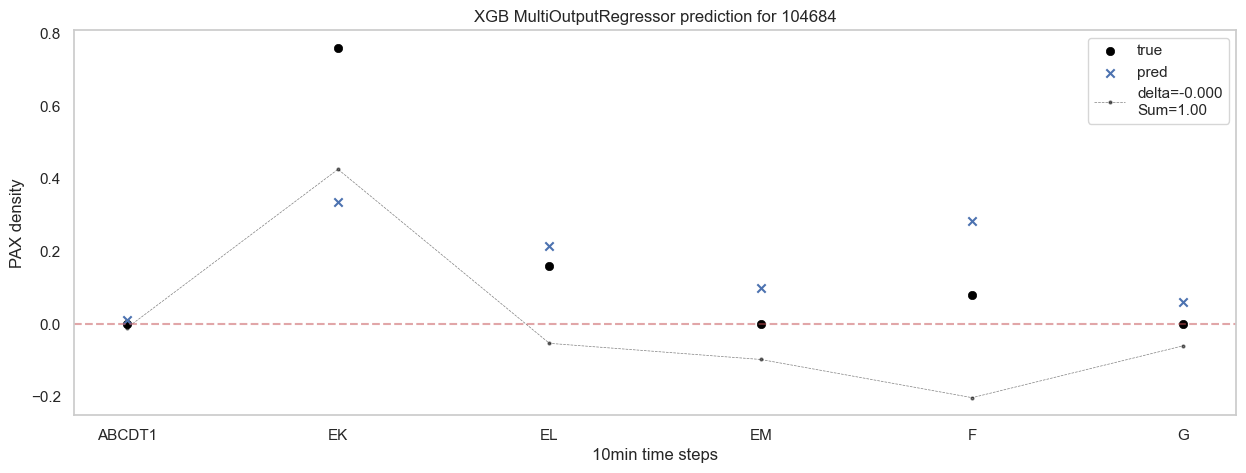

In [34]:
ind = np.random.choice(y_pred.index)
isPlotted=False
while (not isPlotted):
    try:
        isPlotted=True
        plt.figure(figsize=(15, 5))
        plt.scatter(y_full_test.columns, y_full_test.loc[ind], label="true", alpha=1, c="black", linewidth=0.5)
        plt.scatter(y_pred.columns, y_pred.loc[ind], label="pred", marker="x")
        plt.plot(error.loc[ind], label=f"delta={error.loc[ind].sum():.3f}\nSum={y_pred.loc[ind].sum():.2f}", linestyle="--", alpha=0.5, c="black", linewidth=0.5, marker="o", markersize=2)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        plt.ylabel("PAX density")
        plt.xlabel("10min time steps")
        plt.legend()
        plt.title(f"XGB MultiOutputRegressor prediction for {ind}")
        plt.grid()
        # plt.savefig(path_repartition_model + f"\pres_{ind}_{model_name.__name__}.png", bbox_inches='tight')
        plt.show()
    except IndexError:
        isPlotted=False
        ind = np.random.choice(y_pred.index)

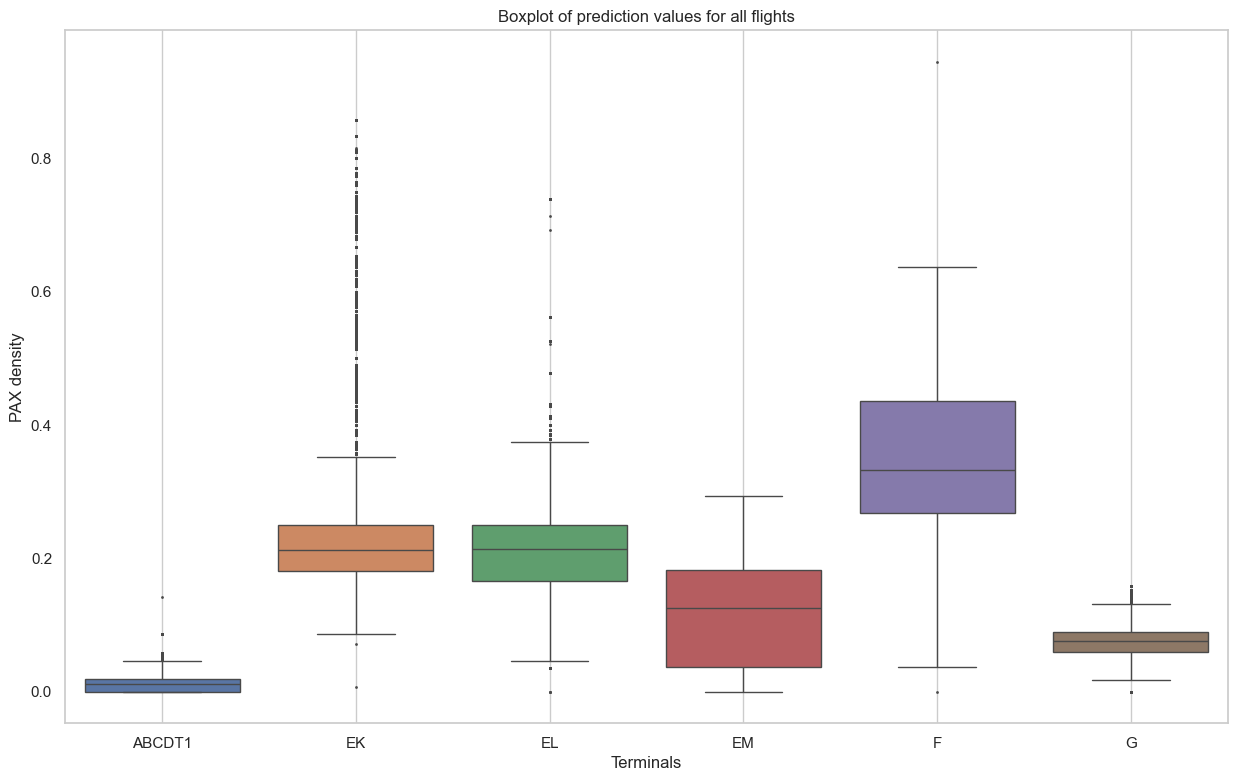

In [37]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 9))
sns.boxplot(data=y_full_test, linewidth=1, fliersize=1)
plt.title(f"Boxplot of prediction values for all flights")
plt.ylabel("PAX density")
plt.xlabel("Terminals")
plt.grid()
plt.show()

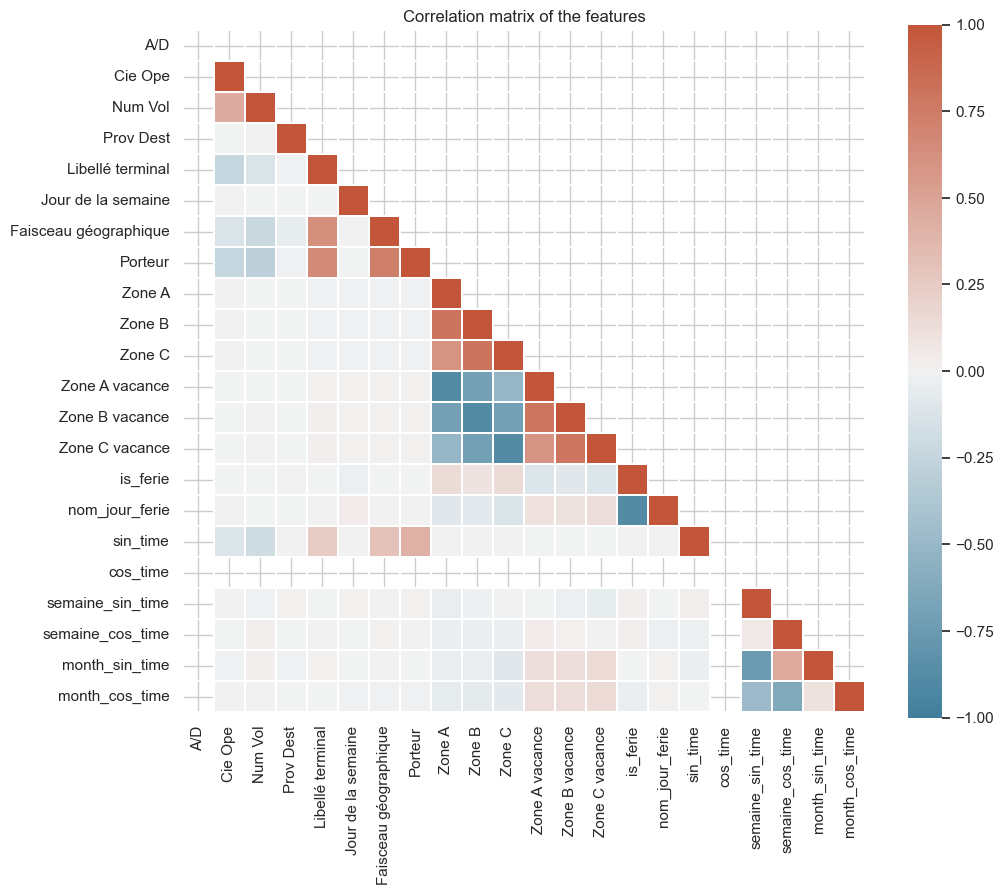

In [23]:
corr = X_full_test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": 1}, annot=False)
plt.title("Correlation matrix of the features")
plt.show()

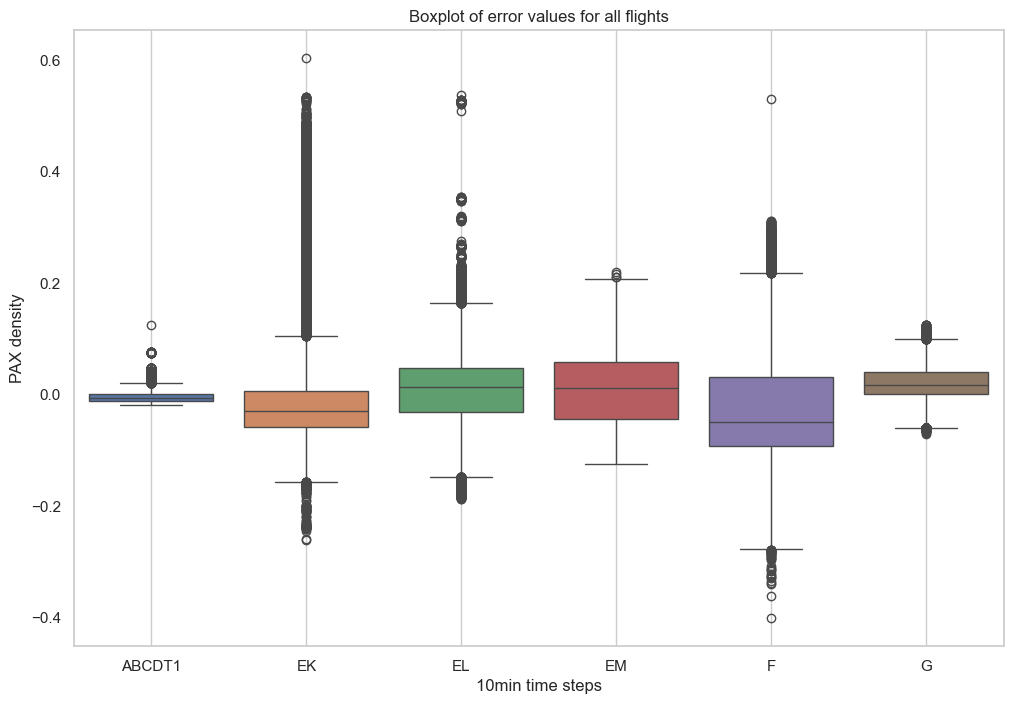

In [24]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=error)
plt.title(f"Boxplot of error values for all flights")
plt.ylabel("PAX density")
plt.xlabel("10min time steps")
plt.grid()
# plt.savefig(path_repartition_model + f"\histo_{ind}_{model_name.__name__}.png", bbox_inches='tight')
plt.show()

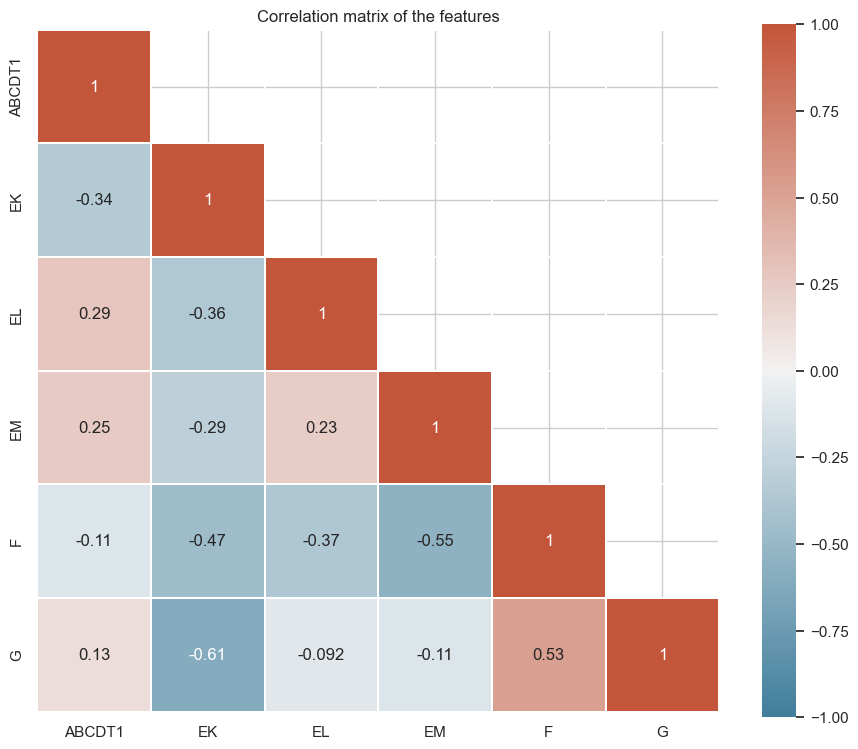

In [38]:
corr = y_full_test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": 1}, annot=True)
plt.title("Correlation matrix of the features")
plt.show()

In [39]:
def score_perfect_pred(dv, alpha, col):
    return ((np.abs(dv[col]) <= float(alpha))).sum() / dv.shape[0]


def plot_perfect_pred_remplissage(dv, col, upper_bound):
    accuracy_pred = pd.DataFrame([score_perfect_pred(dv, alpha, col) for alpha in np.linspace(0, 0.5, 1000)], columns=['accuracy'])
    accuracy_pred_diff =  accuracy_pred.diff() * 10
    row_index = accuracy_pred.loc[accuracy_pred['accuracy'] >= upper_bound].idxmin()
    alpha_5_pct = float(0.5 * (row_index[0])/1000)
    thresh = alpha_5_pct
    plt.figure(figsize=(15, 8))
    plt.plot(np.linspace(0, 0.5, len(accuracy_pred)), accuracy_pred, color='blue', label='Perfect prediction score', linewidth=2)
    plt.plot(np.linspace(0, 0.5, len(accuracy_pred_diff)), accuracy_pred_diff, color='green', label='Rate of change', linewidth=1, linestyle='dashed', alpha=0.5)
    plt.vlines(thresh, 0, score_perfect_pred(dv, thresh, col), color='red', 
               label=f"{score_perfect_pred(dv, thresh, col):.0%} of rows within {thresh:.1%} of true values", linewidth=1, linestyle='dashed')


    plt.hlines(score_perfect_pred(dv, thresh, col), 0, thresh, color='red', linewidth=1, linestyle='dashed')
    plt.hlines(score_perfect_pred(dv, thresh, col), 0, thresh, color='red', linewidth=1, linestyle='dashed')

    plt.title(f"Perfect prediction score for {col}")
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("Score")
    plt.xlim(0, 0.5)
    plt.ylim(0, 1.1)
    # plt.savefig(path + rf"\{model.__name__}_perfect_pred_score.png", bbox_inches='tight')
    plt.show()

    return thresh

def hist_perfect_pred_remplissage(dv):
    mean = dv.mean()
    std = dv.std()
    kurto = dv.kurtosis()
    skew = dv.skew()
    metrics = {"mean": mean, "std": std, "kurto": kurto, "skew": skew}
    plt.figure(figsize=(15, 8))
    sns.histplot(dv, bins=25, kde=True, color='blue', label=f"kurto={round(kurto, 2)}\n skew={round(skew, 2)}")
    plt.vlines(mean, 0, dv.count() * 0.8, color='red', alpha=0.5, label=f"mean={round(mean, 2)}\n std={round(std, 2)}")
    plt.legend()
    plt.title(f"Erreurs de prédiction sur la répartition")
    # plt.savefig(path + rf"\{model.__name__}_perfect_pred_score.png", bbox_inches='tight')
    plt.show()
    return pd.DataFrame(metrics, index=[0])

In [41]:
error_klm_grouped = deepcopy(error)
error_klm_grouped['E'] = error['EK'] + error['EL'] + error['EM']
error_klm_grouped.drop(columns=['EK', 'EL', 'EM'], axis=1, inplace=True)

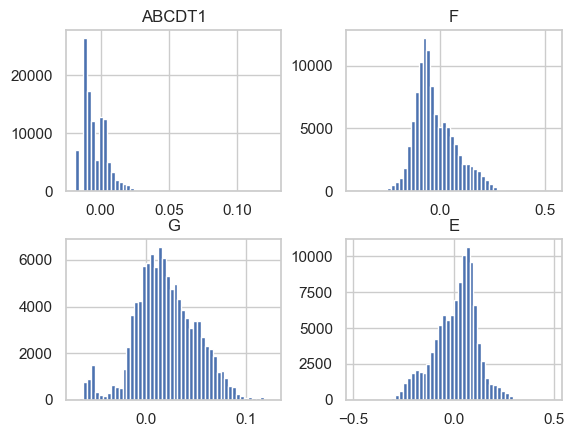

In [43]:
error_klm_grouped.hist(bins=50)
plt.show()


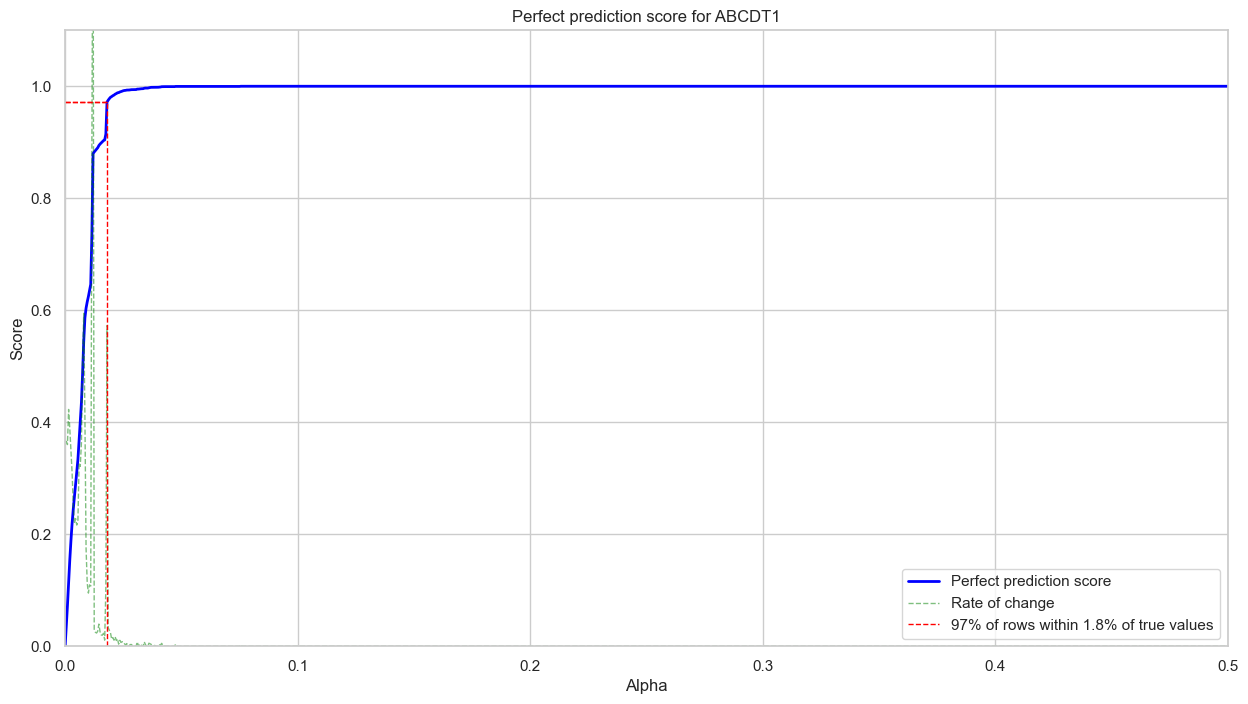

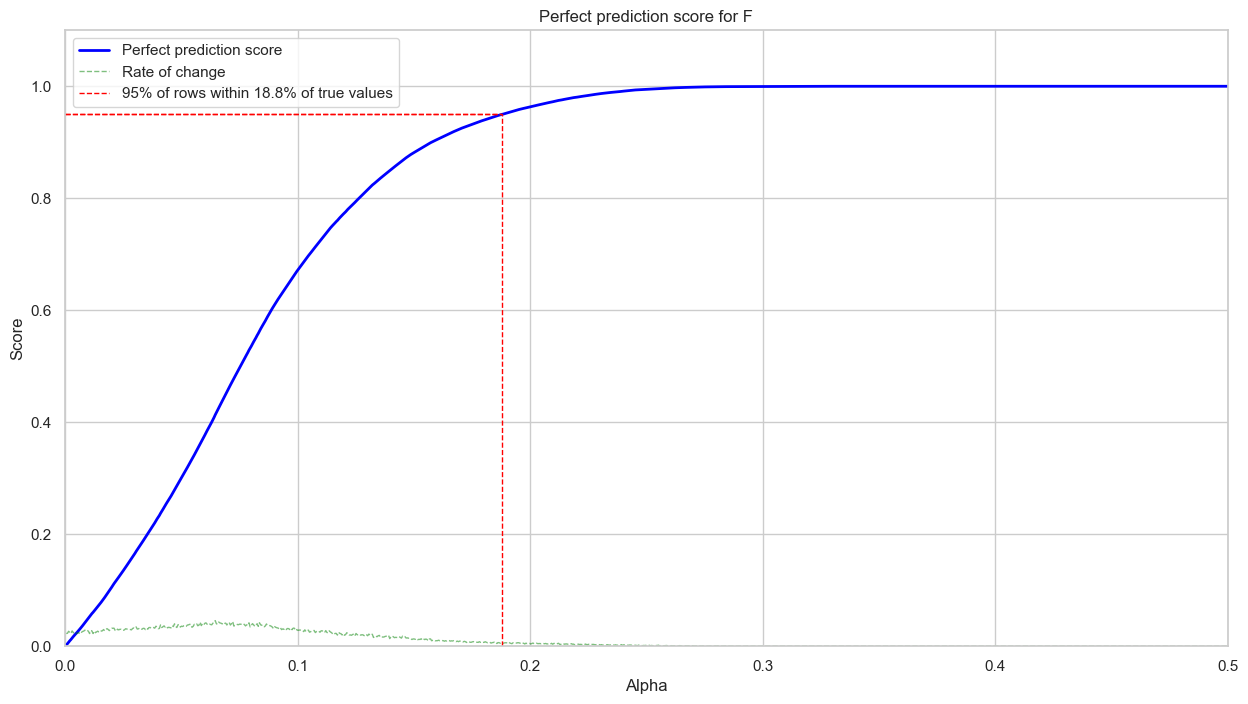

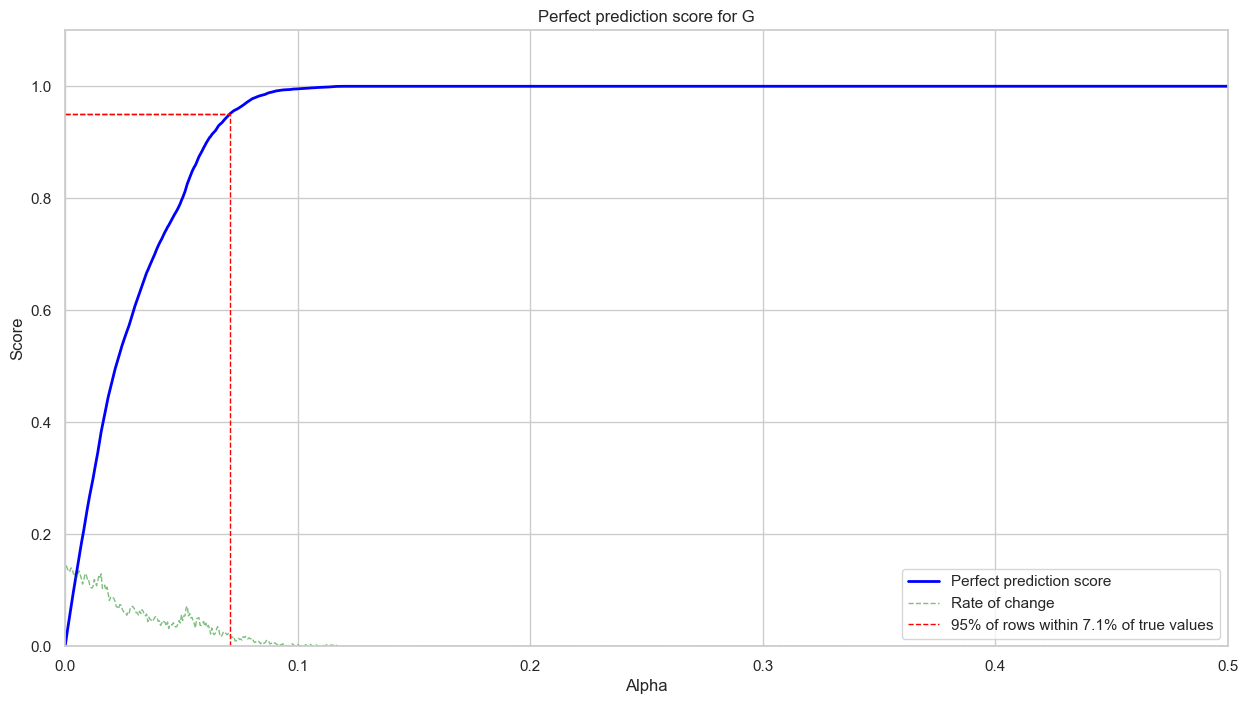

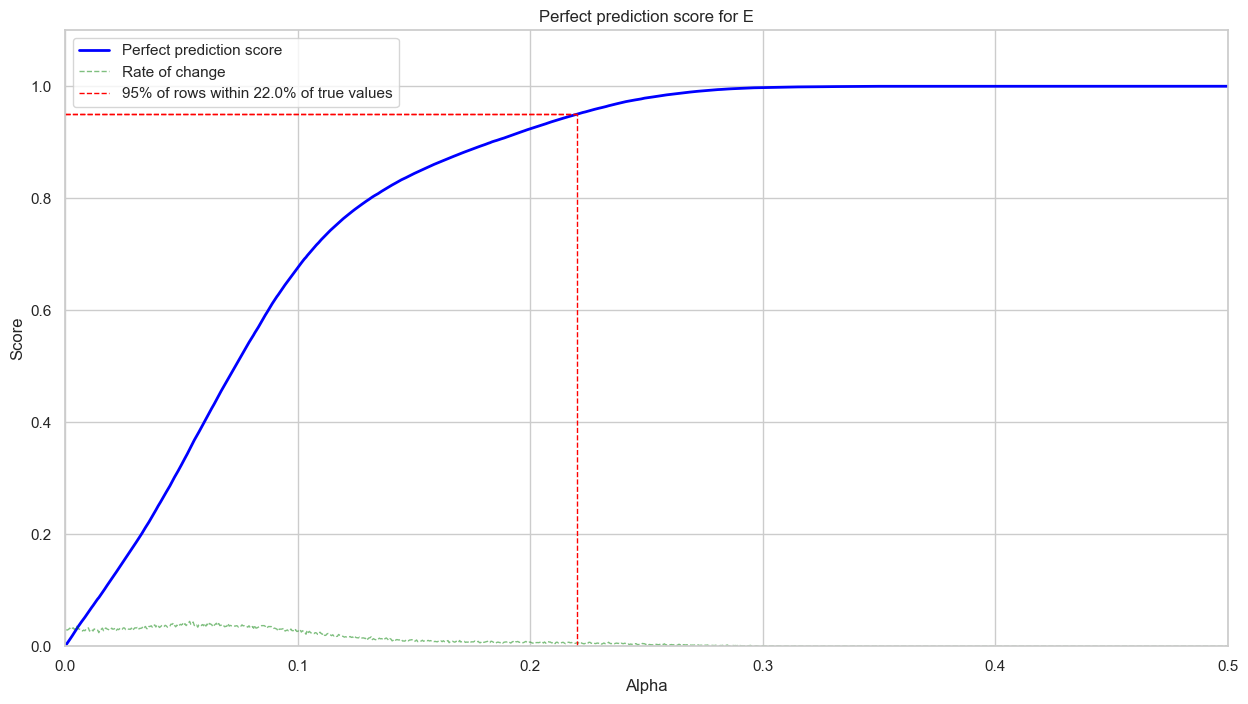

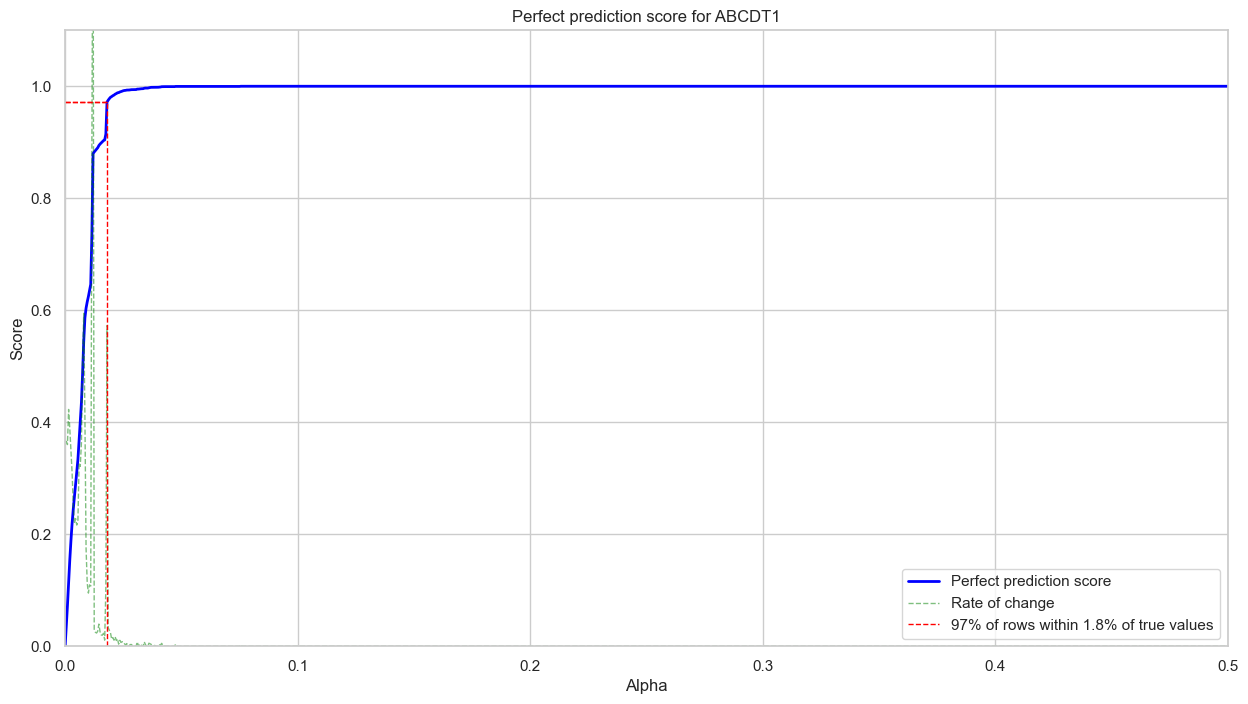

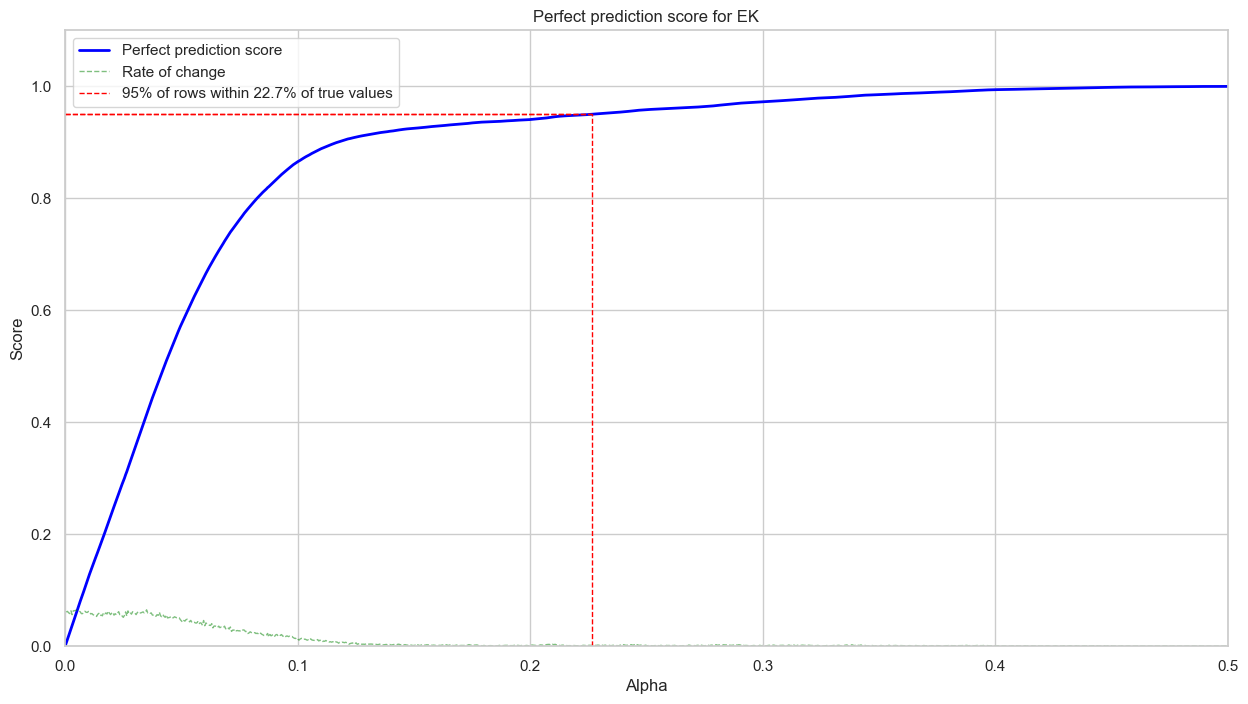

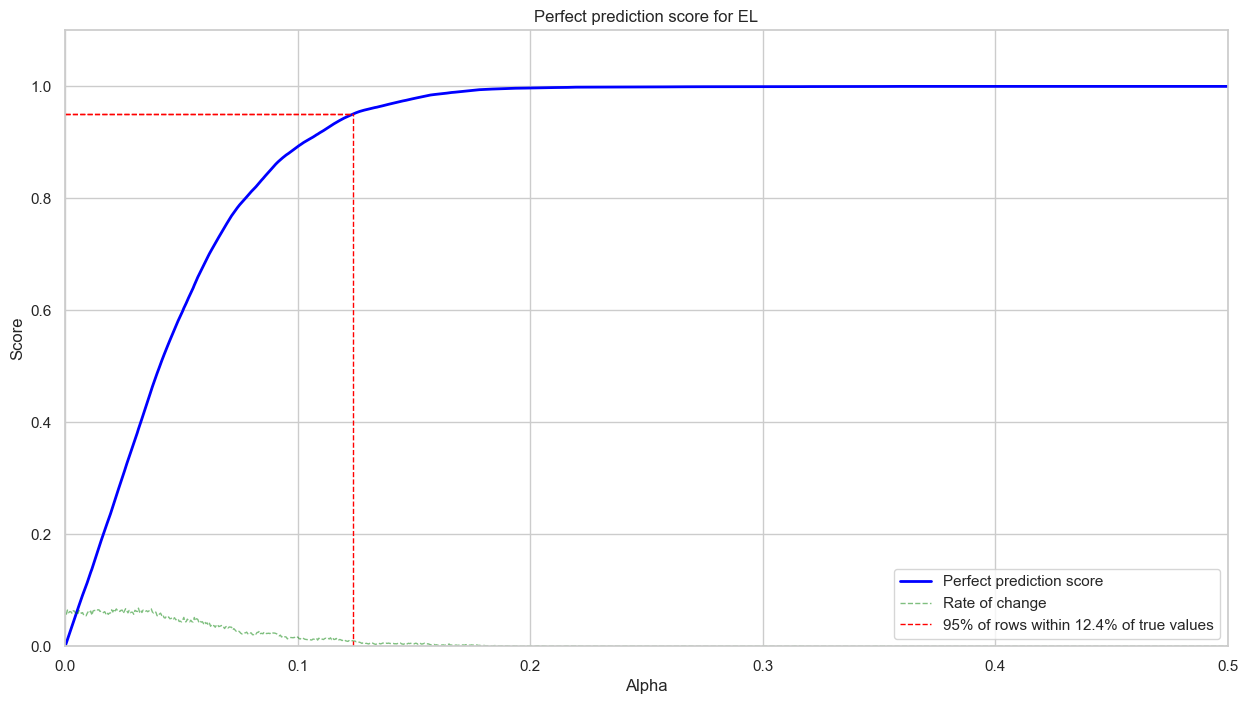

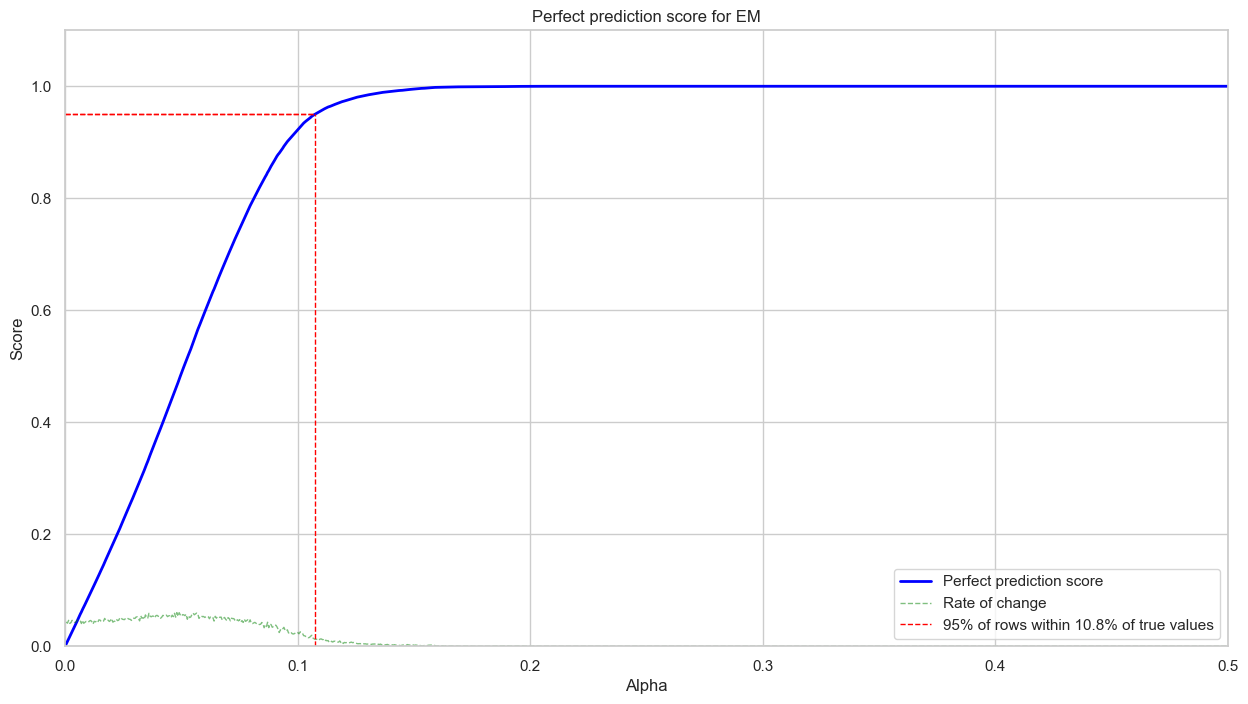

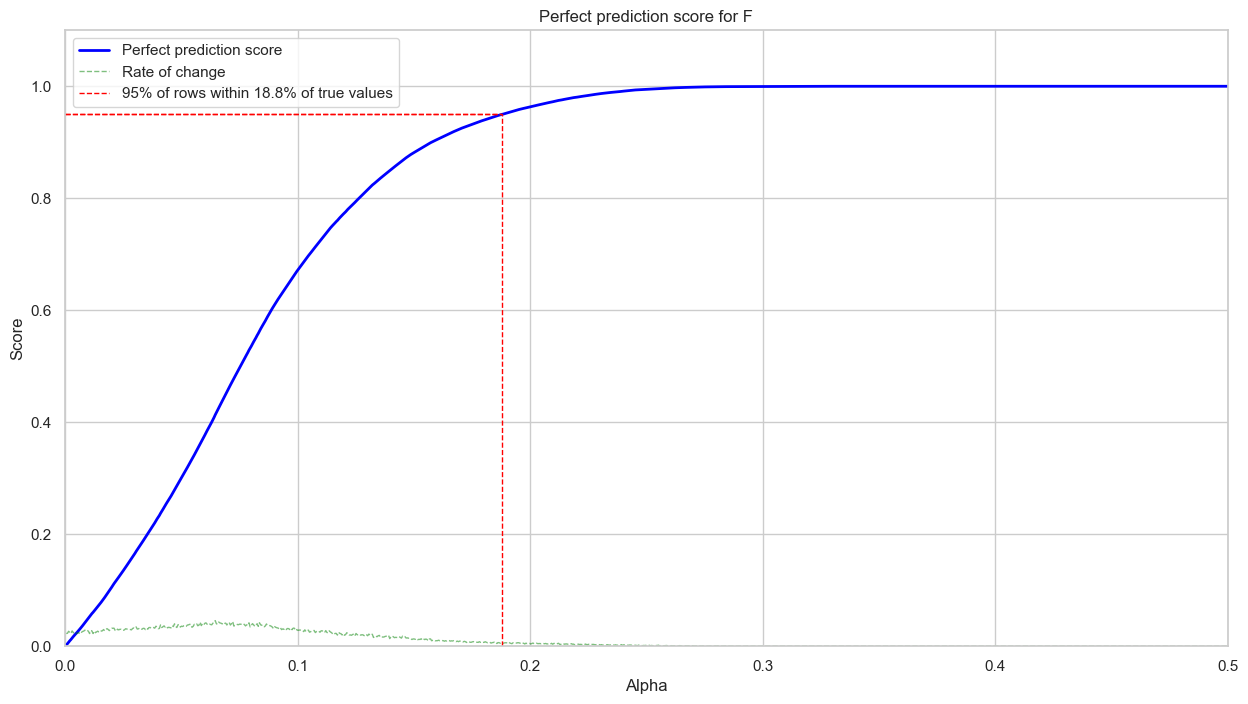

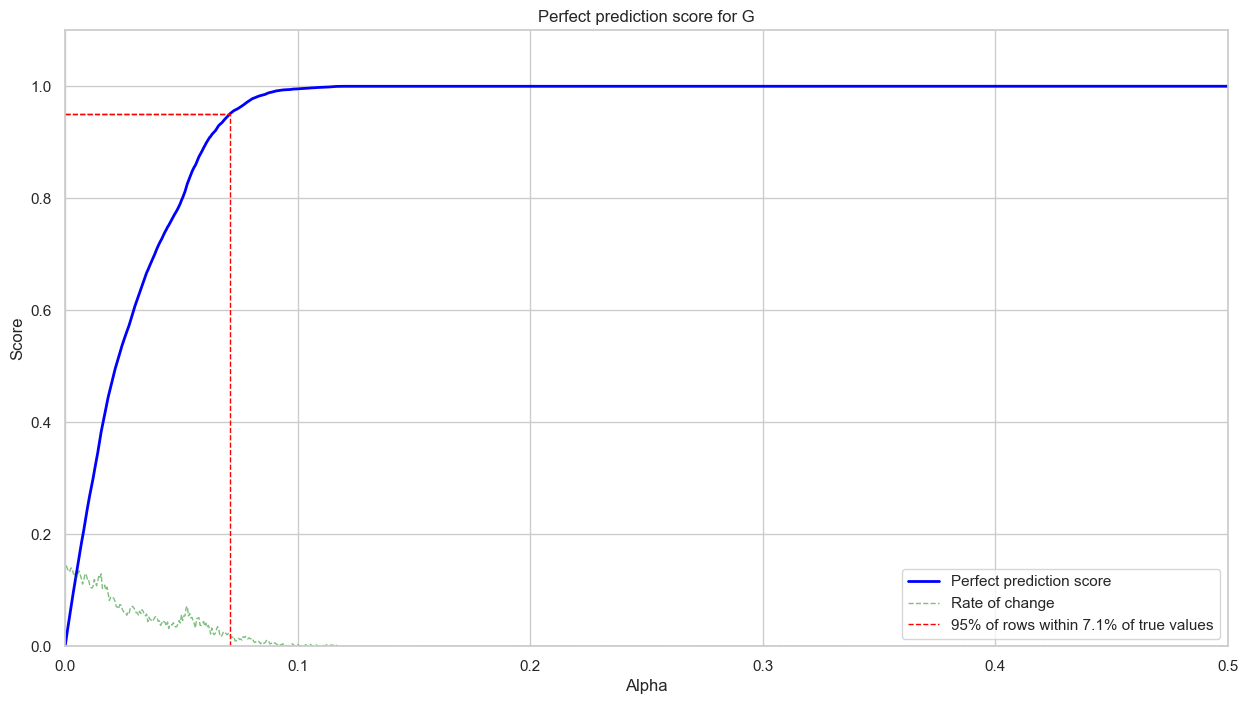

In [44]:
alpha_klm_grouped = {}
alpha = {}
for c in error_klm_grouped.columns:
    alpha_klm_grouped[c] = plot_perfect_pred_remplissage(error_klm_grouped, c, 0.95)
    # plot_perfect_pred_remplissage(delta_values, improved_model_t2e_t2f, path, c)
    # hist_perfect_pred_remplissage(error_klm_grouped[c])
alpha_klm_grouped = pd.DataFrame(alpha_klm_grouped, index=['Ecart'])

for c in error.columns:
    alpha[c] = plot_perfect_pred_remplissage(error, c, 0.95)
    # plot_perfect_pred_remplissage(delta_values, improved_model_t2e_t2f, path, c)
    # hist_perfect_pred_remplissage(error[c])
alpha = pd.DataFrame(alpha, index=['Ecart'])



In [45]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(alpha.T.applymap('{:.2f}'.format))
    display(alpha_klm_grouped.T.applymap('{:.2f}'.format))

,Ecart
ABCDT1,0.02
EK,0.23
EL,0.12
EM,0.11
F,0.19
G,0.07


,Ecart
ABCDT1,0.02
F,0.19
G,0.07
E,0.22


Pred:  1.0000001
True:  1.0


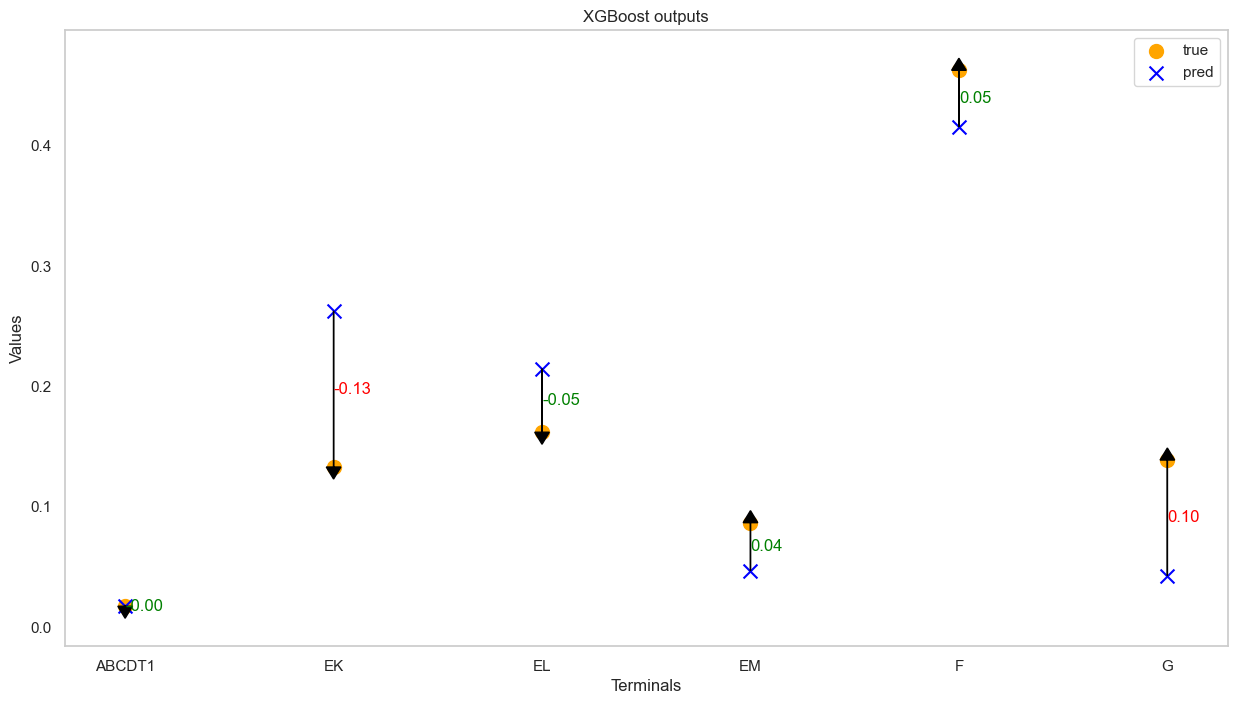

In [52]:
def plot_delta_values_hist(delta_values):
    plt.figure(figsize=(15, 8))
    for i, c in enumerate(delta_values.columns):
        plt.subplot(2, 3, i+1)
        sns.histplot(delta_values[c], stat='density', bins=20, kde=True, color='blue', label=f"{c} \nkurto={round(delta_values[c].kurtosis(numeric_only=True), 2)}\nskew={round(delta_values[c].skew(numeric_only=True), 2)}")
        sns.axes_style("whitegrid")
        plt.legend()
    plt.show()

def plot_prediction(yhat, y_test_encoded, pred_type, data_type):
    isPlotted = False
    while not isPlotted:
        try:
            ind = np.random.choice(yhat.index)
            pred_values = yhat.iloc[ind].values
            true_values = y_test_encoded.iloc[ind].values
            d_values = true_values - pred_values
            plt.figure(figsize=(15, 8))
            print("Pred: ", np.sum(pred_values))
            print("True: ", np.sum(true_values))
            plt.scatter(y_test_encoded.columns, true_values, label="true", s=100, c="orange")
            plt.scatter(y_test_encoded.columns, pred_values, label="pred", s=100, marker="x", c="blue")
            for i, delta in enumerate(d_values):
                plt.arrow(i, pred_values[i], 0, delta, color='black', head_width=0.07, head_length=0.01)
                if np.abs((delta)) <= 0.058:
                    plt.text(i, true_values[i] - delta/2, f'{delta:.2f}', color='green', ha='left', va='center')
                else:
                    plt.text(i, true_values[i] - delta/2, f'{delta:.2f}', color='red', ha='left', va='center')

            plt.legend()
            plt.title(f'XGBoost outputs')
            plt.xlabel('Terminals')
            plt.ylabel('Values')
            plt.grid()
            # path_repartition_model = fr"C:\Users\nazzaren\Desktop\local_data\pif_previs_ml\code\{pred_type}\{data_type}\grid\images"
            # filename = f"\{np.random.randint(0, 100000)}_{model_name.__name__}.png"
            # plt.savefig(path_repartition_model + filename, bbox_inches='tight')
            
            isPlotted = True
        except IndexError:
            isPlotted = False
    # print(filename)



# plot_delta_values_hist(error)
plot_prediction(yhat=y_pred, y_test_encoded=y_test, pred_type='repartition', data_type='T2E_grouped')



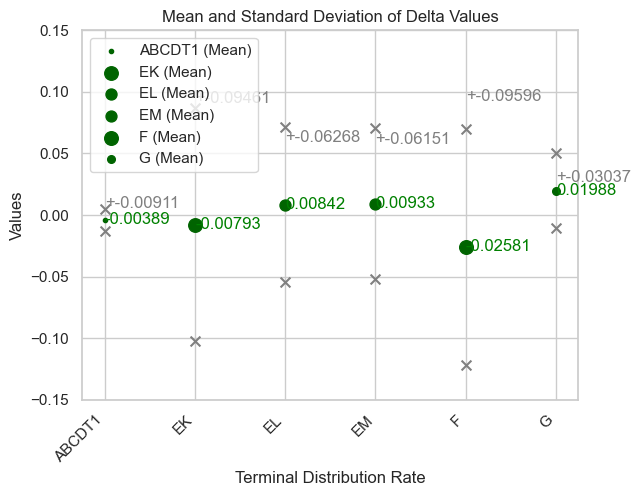

In [53]:
def plot_delta_values_boxplot_custom(delta_values):
    mean_values = []
    std_values = []

    for i, col in enumerate(delta_values.columns):
        mean_val = delta_values[col].mean()
        std_val = delta_values[col].std()

        mean_values.append(mean_val)
        std_values.append(std_val)

        plt.scatter(i, mean_val, label=f'{col} (Mean)', marker="o", color='darkgreen', s=std_val*1000)
        plt.scatter(i, mean_val + std_val, marker="x", color='grey', s=50)
        plt.scatter(i, mean_val - std_val, marker="x", color='grey', s=50)
        plt.text(i, mean_val, f'{mean_val:.5f}', color='green', ha='left', va='center')
        plt.text(i, std_val, f'+-{std_val:.5f}', color='grey', ha='left', va='center')
        plt.grid()

    plt.xticks(np.arange(len(delta_values.columns)), delta_values.columns, rotation=45, ha='right')
    plt.legend()
    plt.ylim(-0.15, 0.15)
    plt.title('Mean and Standard Deviation of Delta Values')
    plt.xlabel('Terminal Distribution Rate')
    plt.ylabel('Values')

    plt.show()

plot_delta_values_boxplot_custom(error)


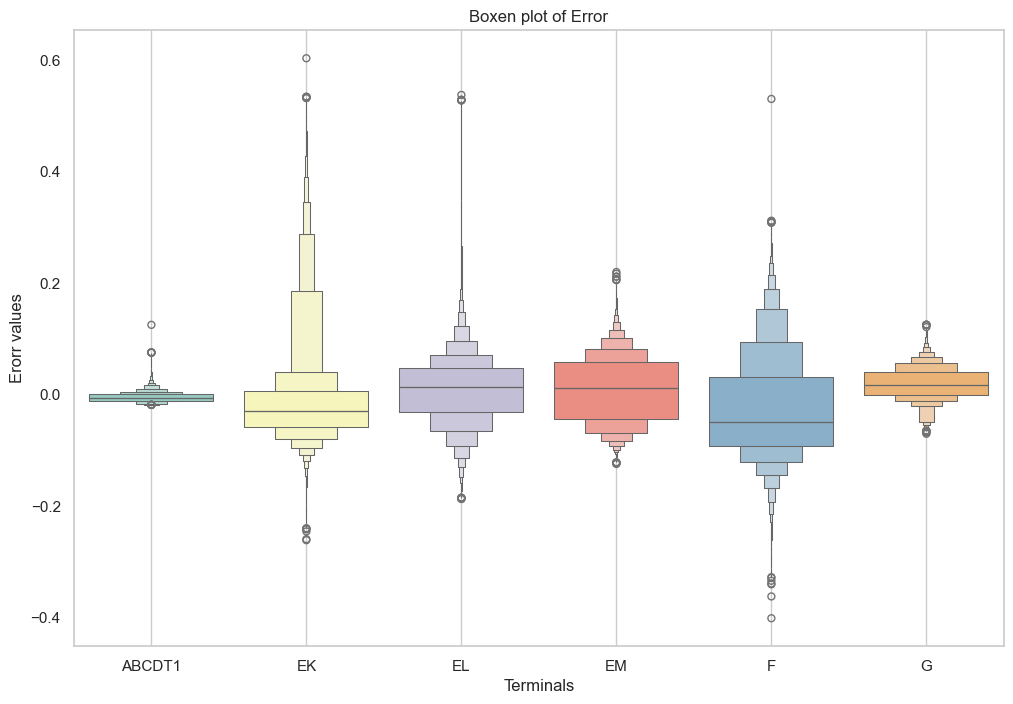

In [54]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxenplot(data=error, palette="Set3")
plt.title(f"Boxen plot of Error")
plt.ylabel("Erorr values")
plt.xlabel("Terminals")
plt.grid()
# plt.savefig(path_repartition_model + f"\histo_{type_data}_{model.__name__}.png", bbox_inches='tight')
plt.show()